In [2]:
import stim
from typing import Tuple, Set, Dict, List
from numpy.typing import NDArray
import numpy as np
import surface_code as sf
import pymatching
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import seaborn as sns

Center Injection  



In [3]:
def LER_postselect(samples: NDArray[np.bool_]) -> list[float]:
    # Assume one observable at the end
    postselected = [s for s in samples if sum(s[:-1]) == 0]
    N = len(postselected)
    n = sum(s[-1] for s in postselected)

    # Logical error rate with postselection
    if N > 0:
        ler_post = n / N

    # Logical error rate without post-selection
    n_total = len(samples)
    n_obs = sum(s[-1] for s in samples)
    ler_no_post = n_obs / n_total

    postselected_rate = N/n_total
    
    return ler_post, ler_no_post, postselected_rate

In [3]:
def circuit_middle_injection(d: int, rounds: int, noise_profile: list[float], inject_state: str) -> stim.Circuit:

    p1, p2, p_M, p_R = noise_profile
    surface_code = sf.RotateSurfaceCode(d)
    full_circuit = stim.Circuit()

    coord_to_index = surface_code.coord_to_index
    data_coords = surface_code.data_coords
    ancilla_coords = surface_code.ancilla_coords

    # Annotate qubits
    for (x, y), index in coord_to_index.items():
        full_circuit.append("QUBIT_COORDS", [index], [x, y])

    def logical_to_physical(coord):
        x, y = coord
        return (2 * (x - 1) + 1, 2 * (y - 1) + 1)
    
    mid = d // 2 + 1
    injection_coord_logical = (mid, mid)

    zero_coords_logical = []
    plus_coords_logical = []

    for x in range(1, d + 1):
        for y in range(1, d + 1):
            if (x, y) == injection_coord_logical:
                continue
            elif (x < y and x + y <= d + 1) or (x > y and x + y >= d + 1):
                zero_coords_logical.append((x, y))
            else:
                plus_coords_logical.append((x, y))


    zero_coords = [logical_to_physical(c) for c in zero_coords_logical if logical_to_physical(c) in coord_to_index]
    plus_coords = [logical_to_physical(c) for c in plus_coords_logical if logical_to_physical(c) in coord_to_index]
    injection_coord = logical_to_physical(injection_coord_logical)

    if injection_coord not in coord_to_index:
        raise ValueError(f"Injection coordinate {injection_coord} not in layout")

    inject_index = coord_to_index[injection_coord]

    # Initialize data qubits
    full_circuit.append_operation("R", [coord_to_index[c] for c in zero_coords])
    full_circuit.append_operation("X_ERROR", [coord_to_index[c] for c in zero_coords], p_R)

    full_circuit.append_operation("RX", [coord_to_index[c] for c in plus_coords])
    full_circuit.append_operation("Z_ERROR", [coord_to_index[c] for c in plus_coords], p_R)

    if inject_state == "Z":
        full_circuit.append_operation("R", [inject_index])
        full_circuit.append_operation("X_ERROR", [inject_index], p_R)
    elif inject_state == "X":
        full_circuit.append_operation("RX", [inject_index])
        full_circuit.append_operation("Z_ERROR", [inject_index], p_R)
    else:
        raise ValueError("inject_state must be 'Z' or 'X'")

    full_circuit.append("TICK")

    # First round of stabilizer measurement
    full_circuit += surface_code.build_standard_sm_round(noise_profile)

    detectors_physical = []
    for x in range(1, d + 2):
        for y in range(1, d + 2):
            is_z_stab = (x + y) % 2 == 0
            is_x_stab = (x + y) % 2 == 1

            keep = False
            if is_z_stab:
                keep = (x < y and x + y < d + 2) or (x > y and x + y > d + 2)
            if is_x_stab:
                keep = (x < y and x + y > d + 2) or (x > y and x + y < d + 2)

            if keep:
                px, py = 2 * (x - 1), 2 * (y - 1)
                if (px, py) in ancilla_coords:
                    detectors_physical.append((px, py))

    for anc in detectors_physical:
        if anc not in ancilla_coords:
            continue
        try:
            k = len(ancilla_coords) - 1 - ancilla_coords.index(anc)
        except ValueError:
            continue
        full_circuit.append_operation("DETECTOR", [stim.target_rec(-k - 1)], list(anc) + [0])

    # Repeated SM rounds
    repeat_circuit = stim.Circuit()
    repeat_circuit.append("TICK")
    repeat_circuit += surface_code.build_standard_sm_round(noise_profile)
    repeat_circuit.append_operation("SHIFT_COORDS", [], [0, 0, 1])

    for k, anc in enumerate(reversed(ancilla_coords)):
        prev = -k - 1 - len(ancilla_coords)
        repeat_circuit.append_operation("DETECTOR", [stim.target_rec(-k - 1), stim.target_rec(prev)], list(anc) + [0])

    full_circuit += repeat_circuit * (rounds - 1)

    # Final data measurement
    data_indices = [coord_to_index[c] for c in data_coords]
    if inject_state == "X":
        full_circuit.append_operation("H", data_indices)
    full_circuit.append_operation("M", data_indices)

    # Logical observables
    if inject_state == "X":
        logical_logical = [(d//2 + 1, y) for y in range(1, d + 1)]  # Z observable (row)
    elif inject_state == "Z":
        logical_logical = [(x, d//2 + 1) for x in range(1, d + 1)]  # X observable (column)
    else:
        raise ValueError("inject_state must be 'Z' or 'X'")

    logical_physical = [logical_to_physical(c) for c in logical_logical if logical_to_physical(c) in coord_to_index]
    logical_targets = [
        stim.target_rec(-1 - data_coords[::-1].index(c))
        for c in logical_physical
    ]
    full_circuit.append("OBSERVABLE_INCLUDE", logical_targets, 0)

    return full_circuit


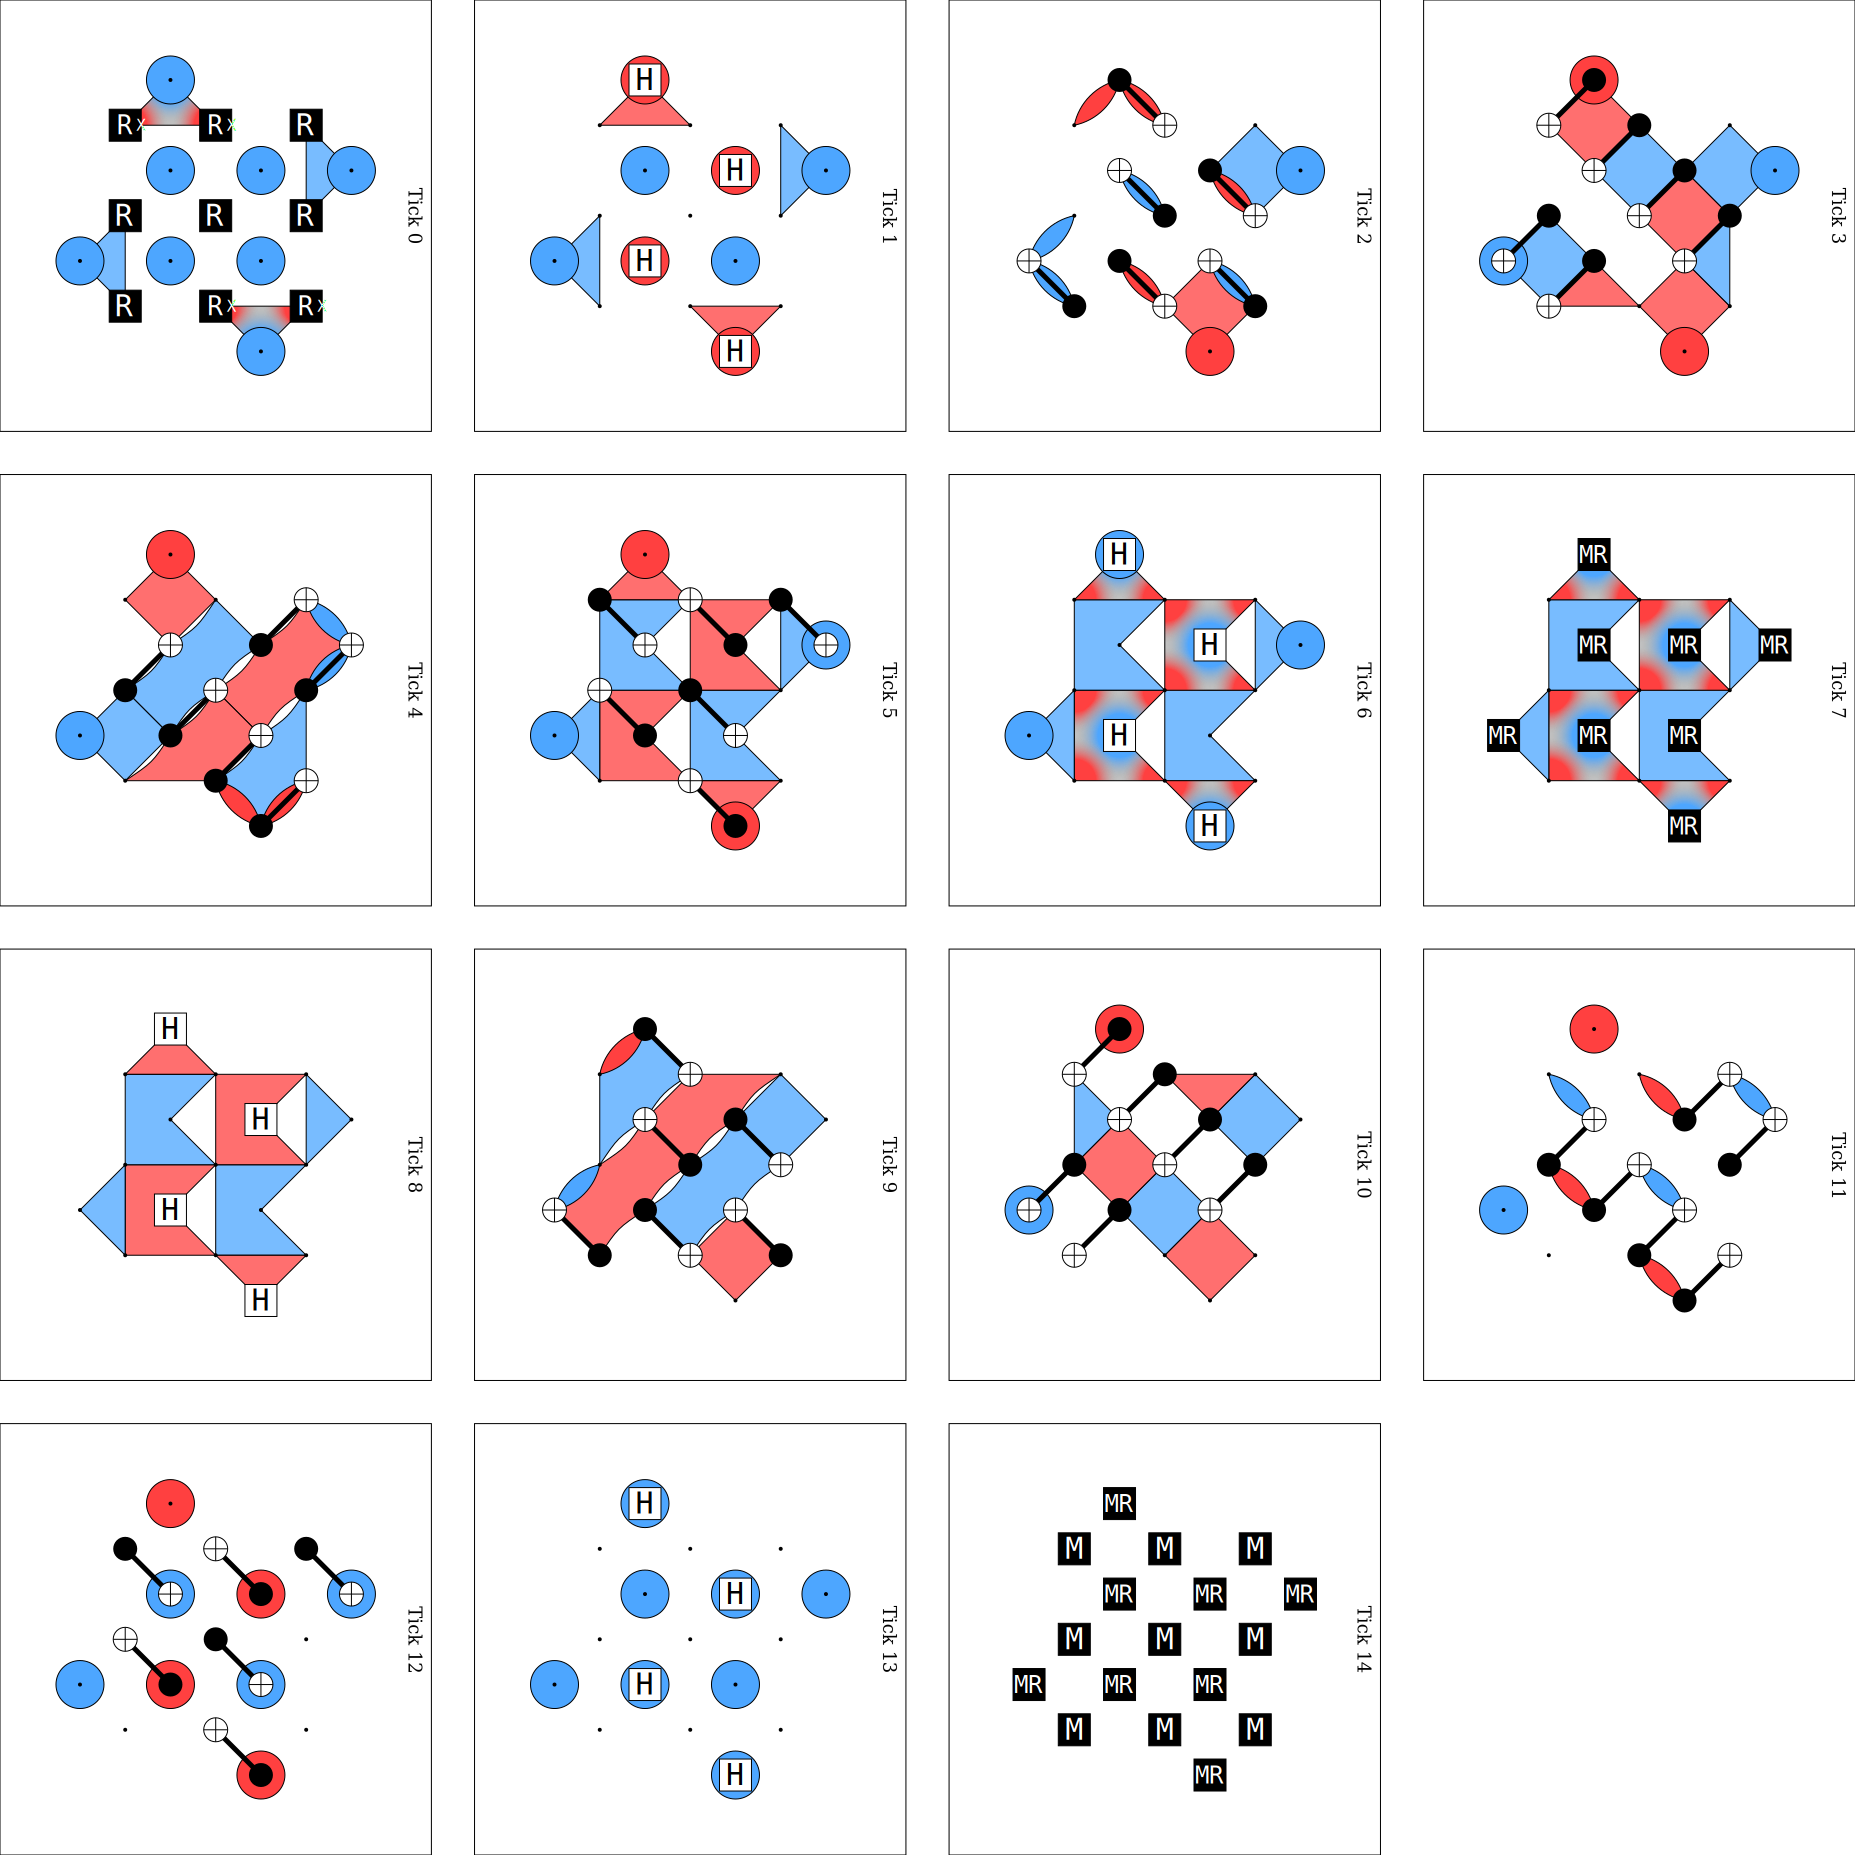

In [75]:
d = 3  
rounds = 2
noise_profile = [0, 1e-3, 0, 0]  # [p1, p2, p_M, p_R]

middle_inject_Z = circuit_middle_injection(d, rounds, noise_profile, "Z")
middle_inject_X = circuit_middle_injection(d, rounds, noise_profile, "X")

# Visualize noiseless circuit detector slice
middle_inject_Z.without_noise().diagram("detslice-with-ops-svg")

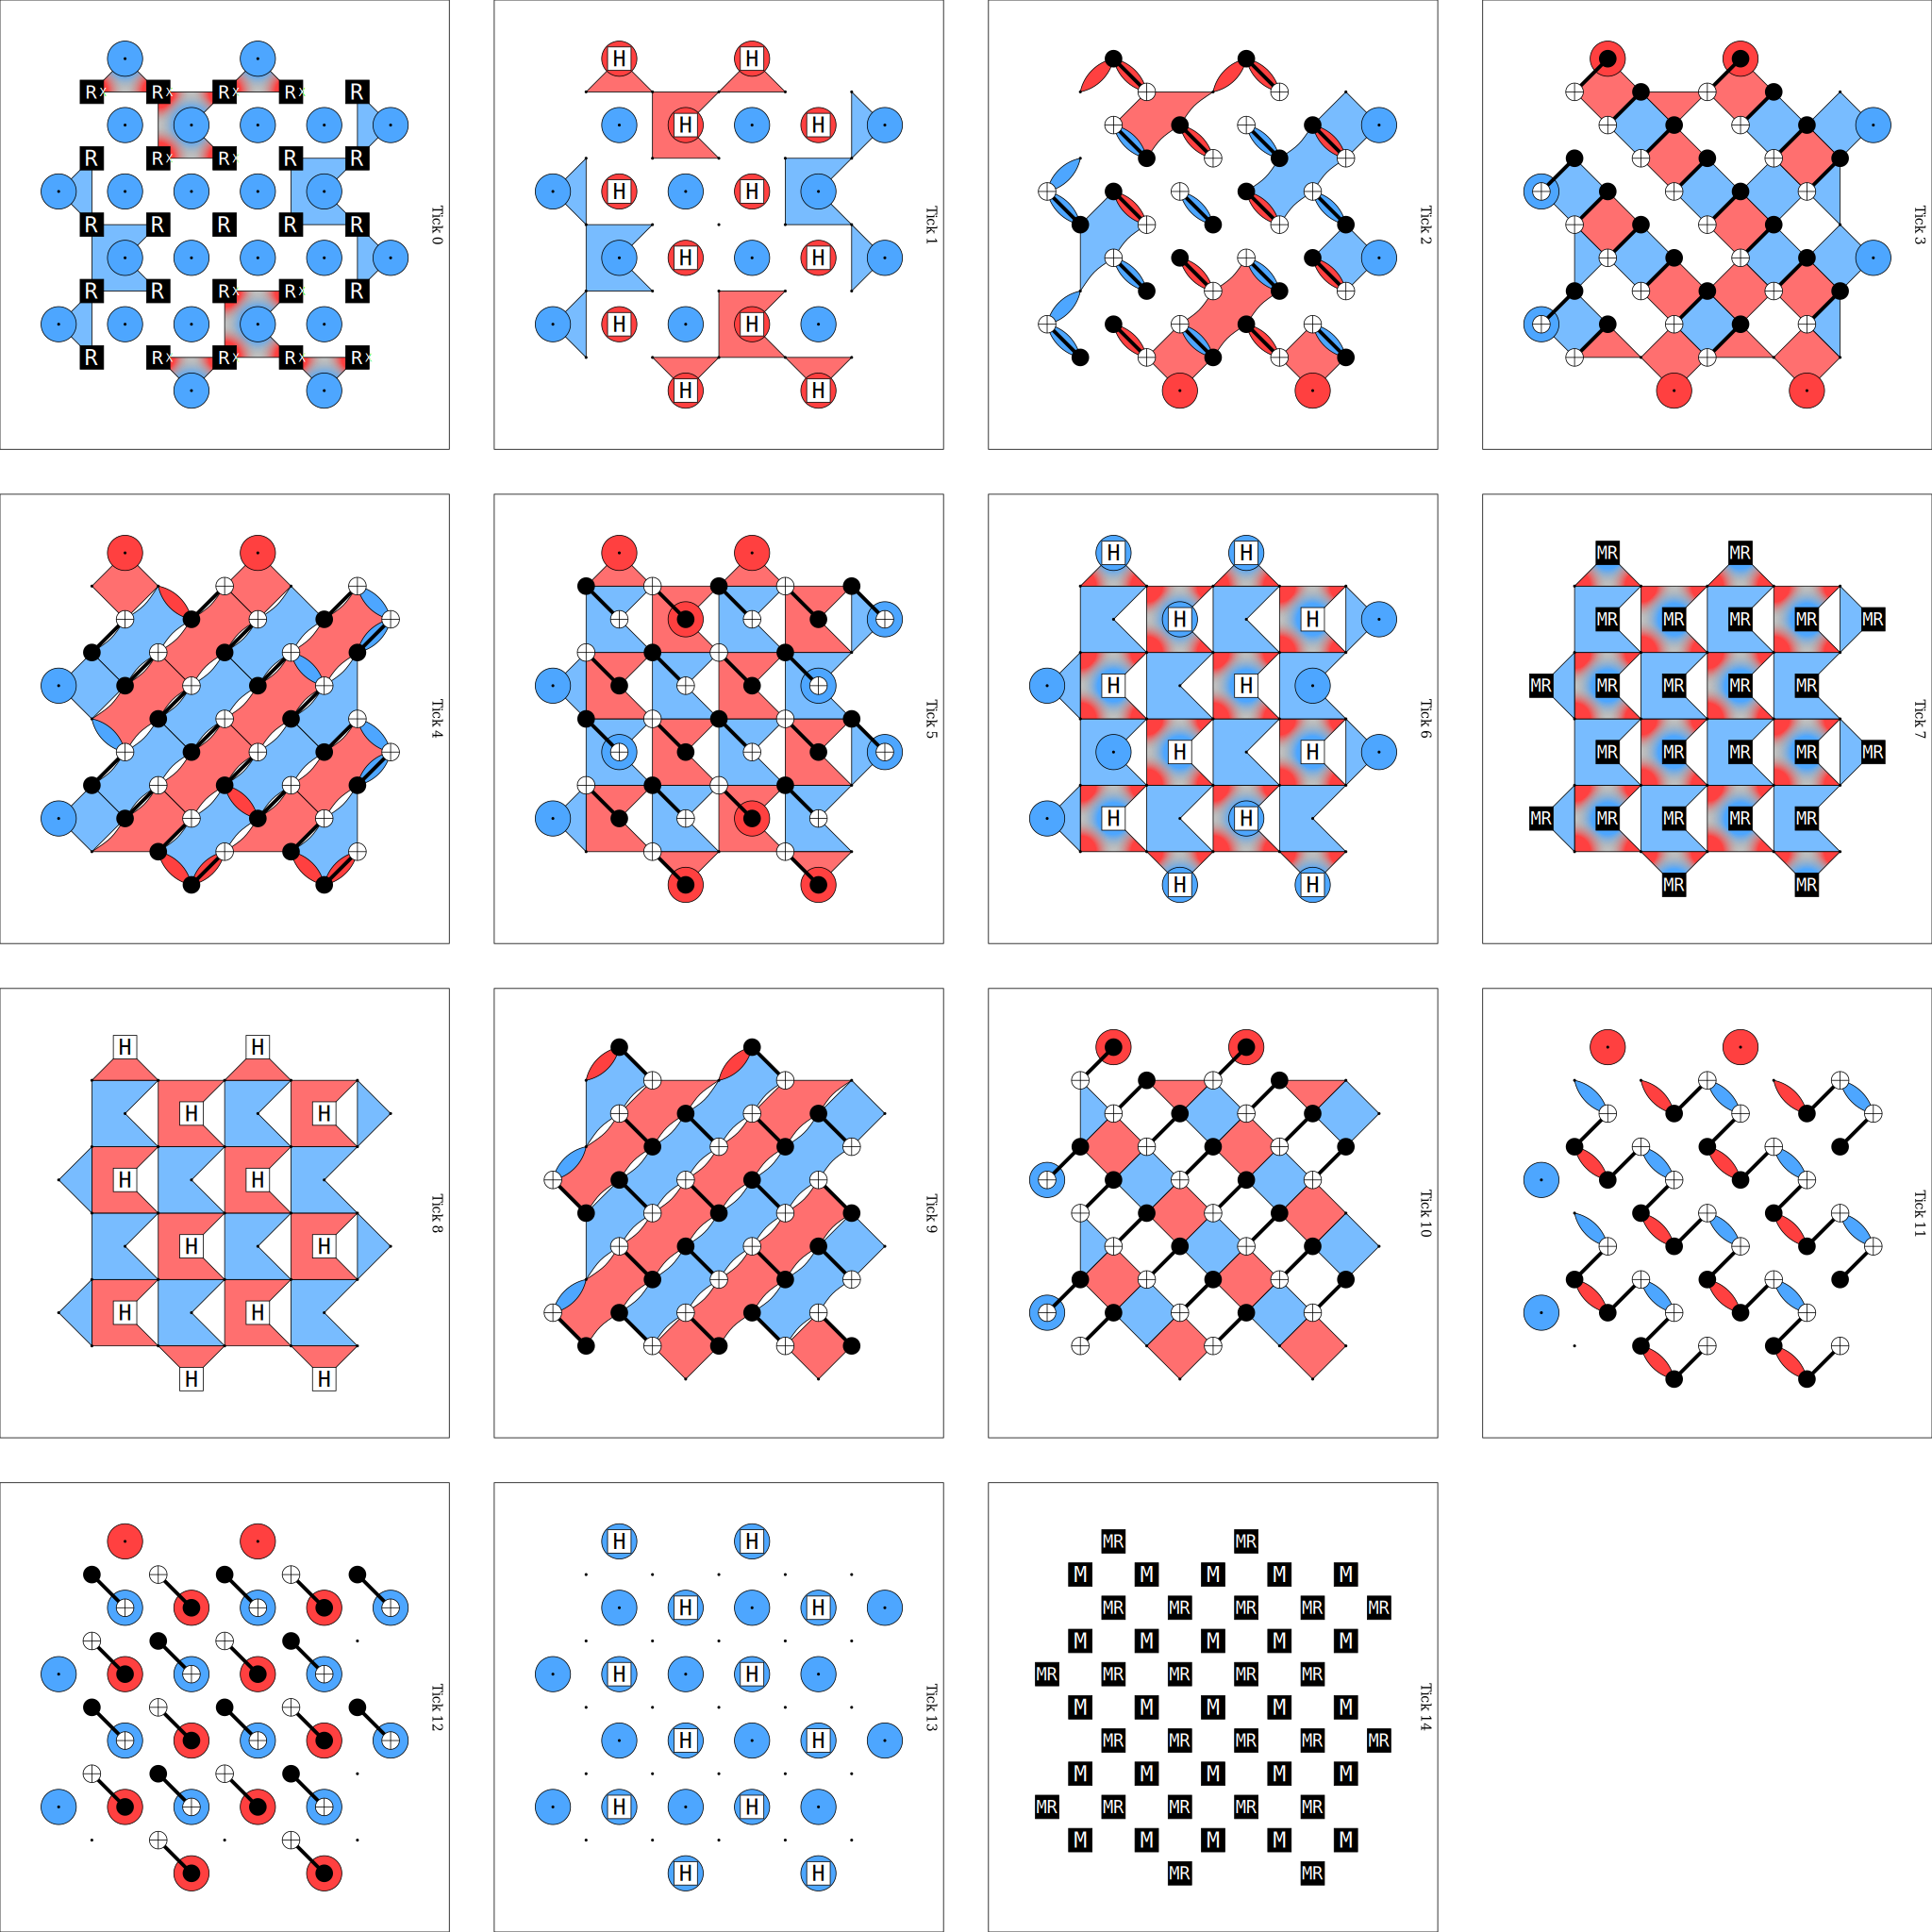

In [76]:
d = 5  
rounds = 2
noise_profile = [0, 1e-3, 0, 0]  # [p1, p2, p_M, p_R]

middle_inject_Z = circuit_middle_injection(d, rounds, noise_profile, "Z")
middle_inject_X = circuit_middle_injection(d, rounds, noise_profile, "X")

# Visualize noiseless circuit detector slice
middle_inject_Z.without_noise().diagram("detslice-with-ops-svg")

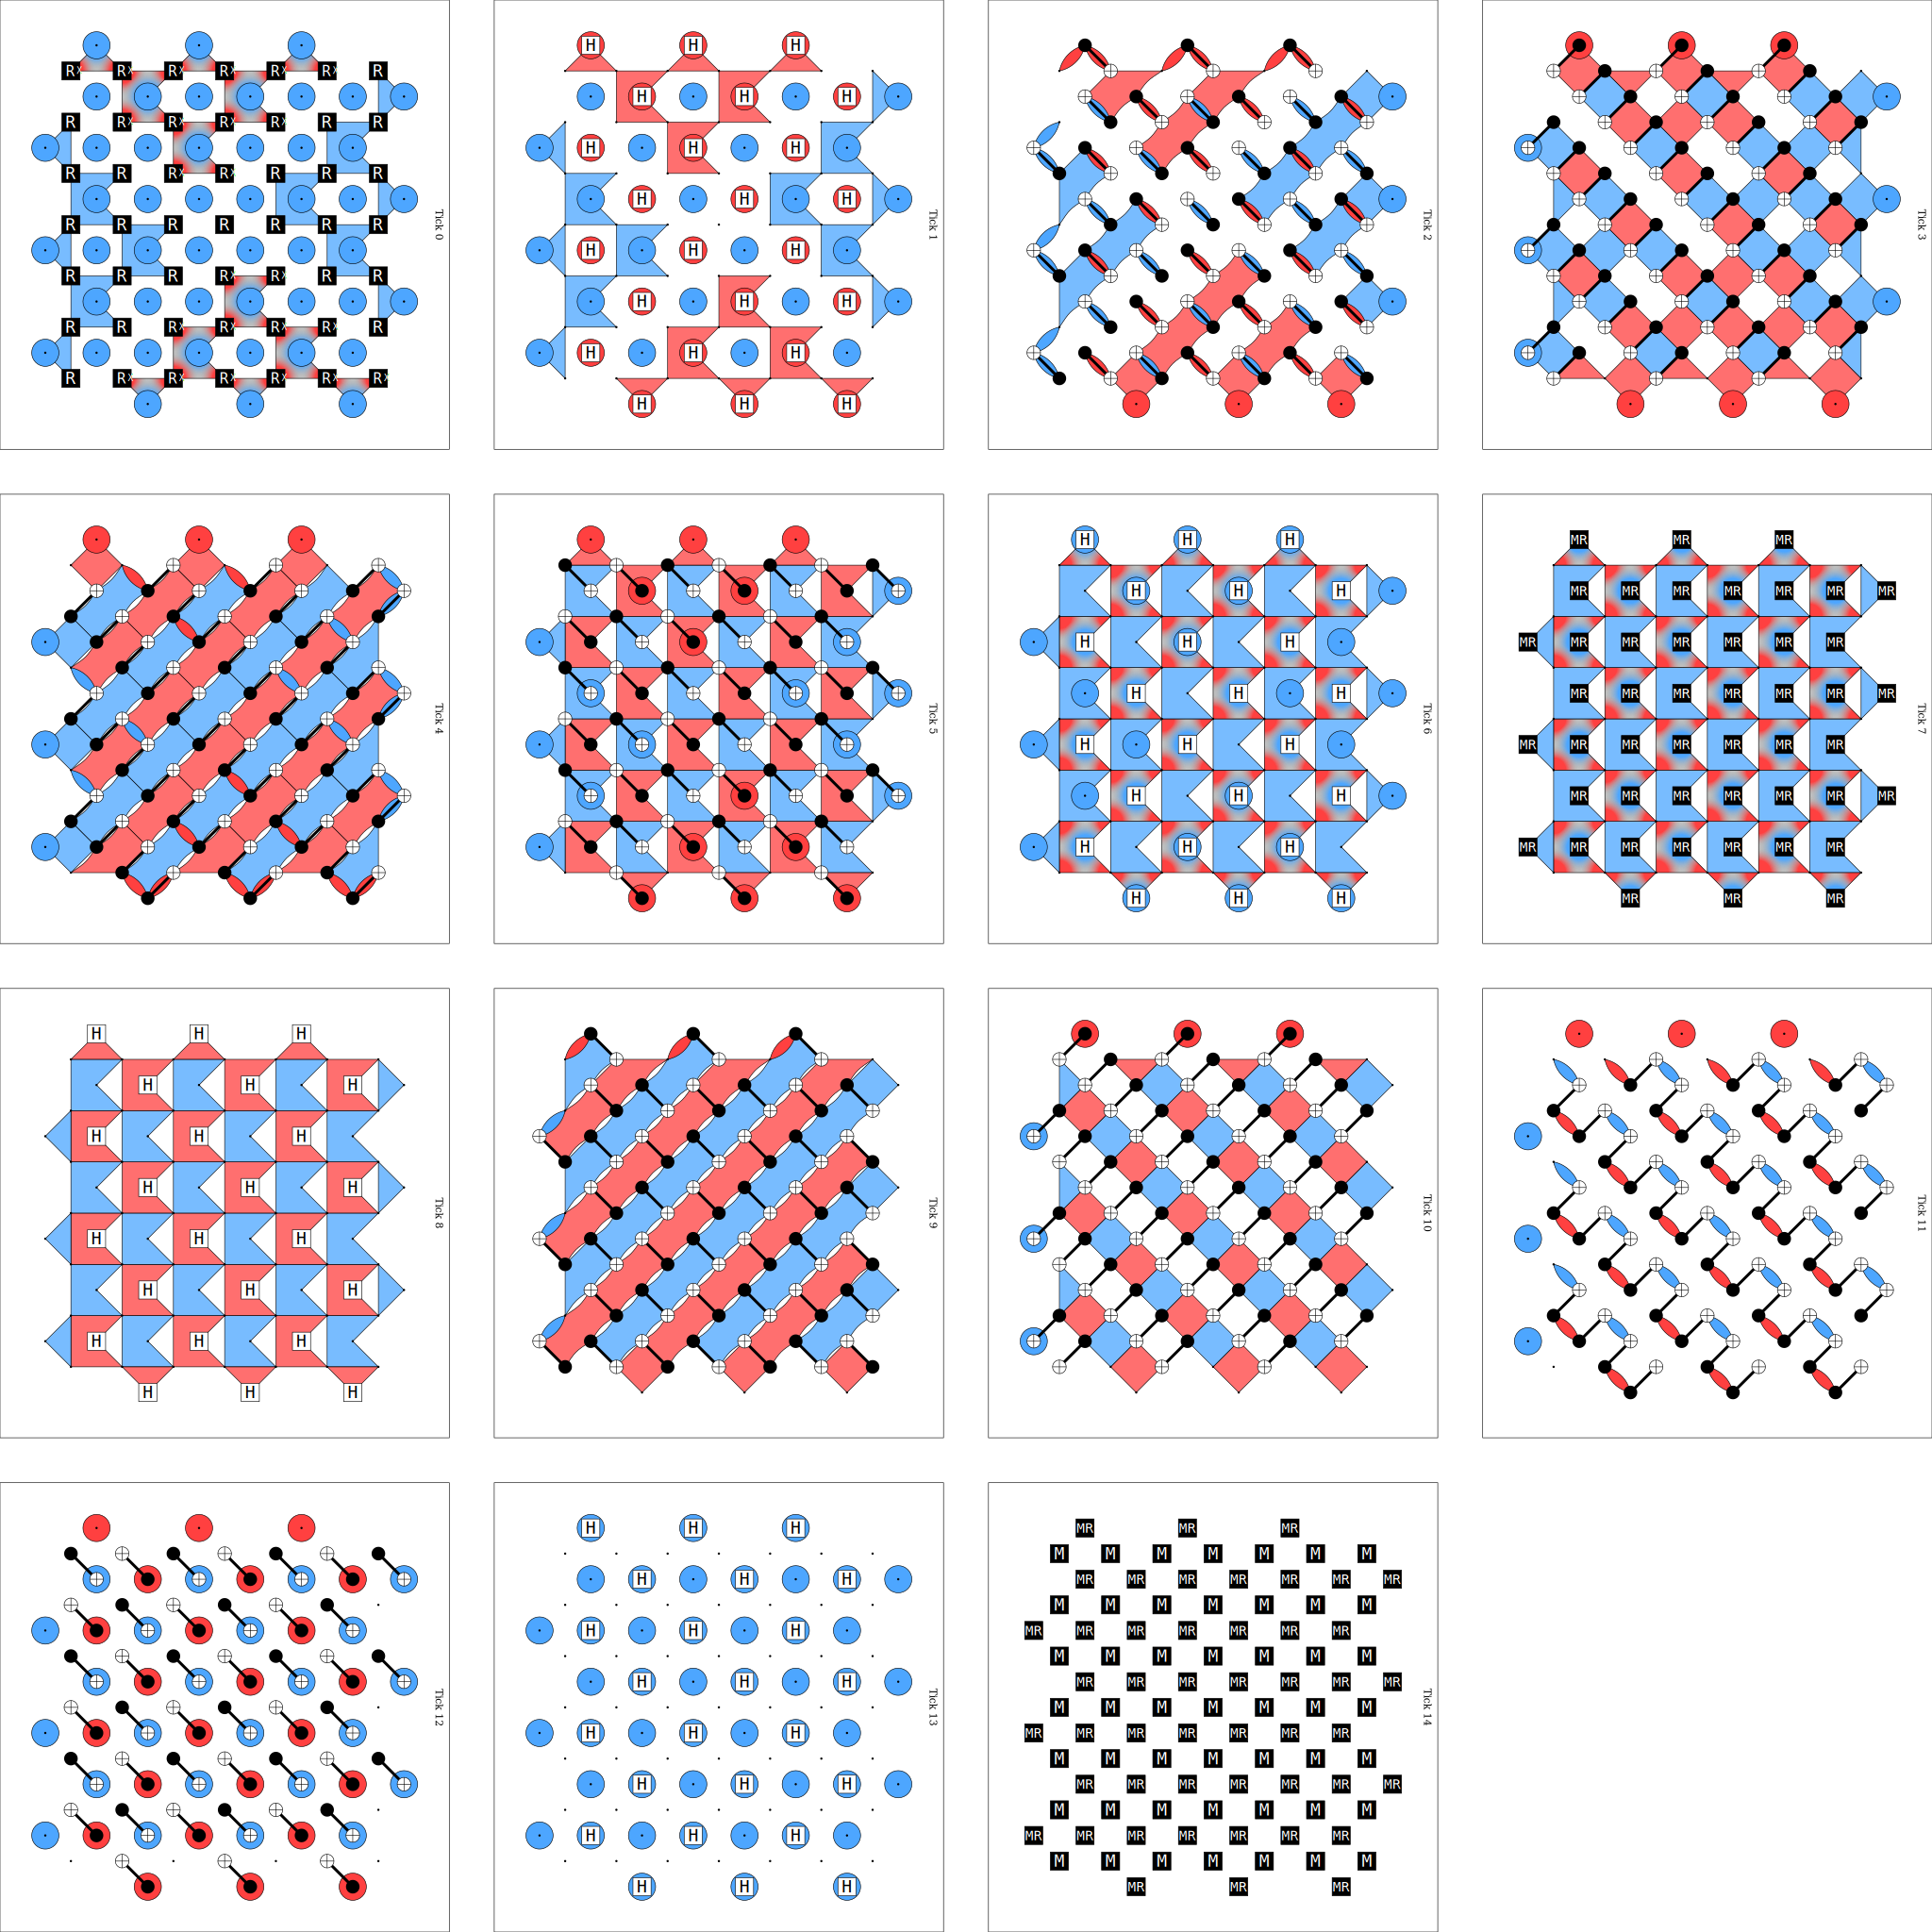

In [77]:
d = 7  
rounds = 2
noise_profile = [0, 1e-3, 0, 0]  # [p1, p2, p_M, p_R]

middle_inject_Z = circuit_middle_injection(d, rounds, noise_profile, "Z")
middle_inject_X = circuit_middle_injection(d, rounds, noise_profile, "X")

# Visualize noiseless circuit detector slice
middle_inject_Z.without_noise().diagram("detslice-with-ops-svg")

In [78]:
num_shots = 1000000
samples_Z5 = middle_inject_Z.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: Z")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_Z5)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")
samples_X5 = middle_inject_X.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: X")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_X5)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")

Inject state: Z
LER_post: 0.0028996991279630177, LER_no_post: 0.02722, Post-selection Rate: 0.752147
Inject state: X
LER_post: 0.003095473219305439, LER_no_post: 0.027152, Post-selection Rate: 0.752389
